# ElasticNet
* A mix of Lasso (L1) and Ridge (L2) regularization.
* Helps when some features are important but others need to be reduced, striking a balance between feature selection and keeping all features useful.

In [70]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
import warnings
import pandas as pd
import numpy as np



# Get data
train_2016 = pd.read_csv('zillow-data/train_2016_v2.csv')
train_2017 = pd.read_csv('zillow-data/train_2017.csv')
properties_2016 = pd.read_csv('zillow-data/properties_2016.csv')
properties_2017 = pd.read_csv('zillow-data/properties_2017.csv')
sample_submission = pd.read_csv('zillow-data/sample_submission.csv')
warnings.filterwarnings('ignore')

# merge datasets
merged_data_2016 = pd.merge(properties_2016, train_2016, on='parcelid')
merged_data_2017 = pd.merge(properties_2017, train_2017, on='parcelid')
data = pd.concat([merged_data_2016, merged_data_2017], ignore_index=True)



In [71]:
from sklearn.cluster import KMeans

missing_coords = data[['latitude', 'longitude']].isnull().sum()
print(missing_coords)
#drop rows with missing coordinates
data = data.dropna(subset=['latitude', 'longitude'])

num_clusters = 50  # Adjust based on dataset size
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['location_cluster'] = kmeans.fit_predict(data[['latitude', 'longitude']])
# remove outliers
data = data[np.abs(data['logerror'] - data['logerror'].mean()) < 6 * data['logerror'].std()]

#split data into x and y
selected_features = [
    'taxvaluedollarcnt',
    'bedroomcnt', 'yearbuilt', 'location_cluster']

x = data[selected_features]
y = data['logerror']

latitude     34
longitude    34
dtype: int64


In [72]:
#fill missing values with median
x = x.fillna(x.median())
print(x.isnull().sum().sum())

#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

0


## Standardize the Data

In [73]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and testing sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

# Convert back to DataFrame (optional, but helpful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Mean should be super small, Std should be super close to 1
print(X_train_scaled.describe())  

       taxvaluedollarcnt    bedroomcnt     yearbuilt  location_cluster
count       1.337270e+05  1.337270e+05  1.337270e+05      1.337270e+05
mean        1.365539e-17  1.224203e-16 -3.511920e-15      1.148753e-16
std         1.000004e+00  1.000004e+00  1.000004e+00      1.000004e+00
min        -7.859467e-01 -2.645160e+00 -6.103206e+00     -1.668785e+00
25%        -4.476618e-01 -9.050899e-01 -6.587781e-01     -8.163057e-01
50%        -2.018254e-01 -3.505463e-02  5.870469e-02     -3.486629e-02
75%         1.381918e-01  8.349806e-01  7.761875e-01      7.465731e-01
max         8.108922e+01  1.127540e+01  2.000129e+00      1.812172e+00


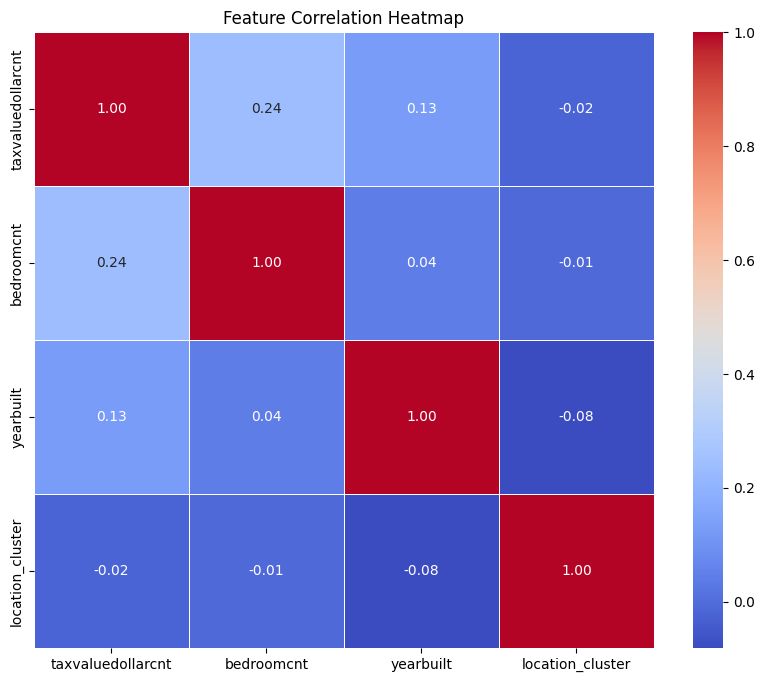

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

## Find best L1 and Alpha

In [75]:
elastic_net = ElasticNetCV(
    l1_ratio=np.linspace(0.01, 1, 10),  # Test more values between Lasso (1) and Ridge (0)
    alphas=np.logspace(-6, 1, 50),  # Adjust regularization strength range
    cv=10,  # Use more folds for cross-validation
    max_iter=5000,  # Increase iterations for better convergence
    n_jobs=-1  # Use all available CPU cores
)
elastic_net.fit(X_train_scaled, y_train)

print("Best Alpha:", elastic_net.alpha_)
print("Best L1 Ratio:", elastic_net.l1_ratio_)

Best Alpha: 0.0013894954943731374
Best L1 Ratio: 0.01


##  Evaluate the Model's Performance

In [76]:
from sklearn.metrics import mean_squared_error, r2_score

# Make predictions
y_train_pred = elastic_net.predict(X_train_scaled)
y_test_pred = elastic_net.predict(X_test_scaled)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Print results
print(f"Training MSE: {train_mse:.5f}")
print(f"Testing MSE: {test_mse:.5f}")
print(f"Training R²: {train_r2:.5f}")
print(f"Testing R²: {test_r2:.5f}")

Training MSE: 0.01284
Testing MSE: 0.01351
Training R²: 0.00129
Testing R²: 0.00206


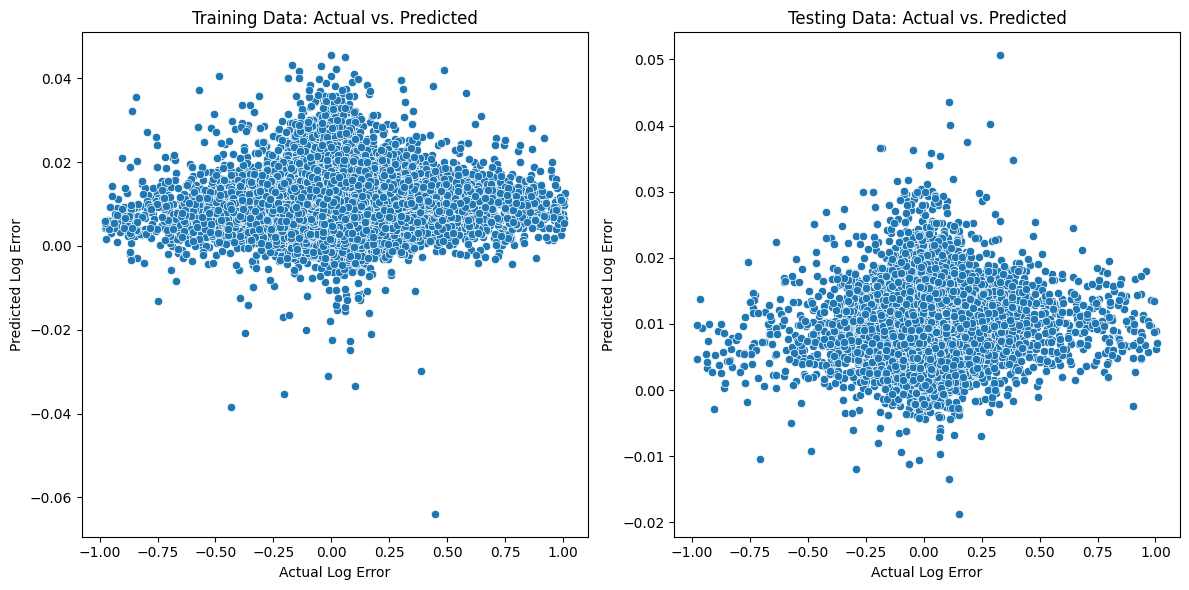

In [77]:
# Plot Actual vs Predicted for Training Data
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Training Data: Actual vs. Predicted")

# Plot Actual vs Predicted for Testing Data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Testing Data: Actual vs. Predicted")

plt.tight_layout()
plt.show()

In [78]:
# Extract parcel IDs
parcel_ids = sample_submission['ParcelId']

# Ensure your test data includes only these parcel IDs
test_data = properties_2017[properties_2017['parcelid'].isin(parcel_ids)]

test_data['latitude'].fillna(test_data['latitude'].median(), inplace=True)
test_data['longitude'].fillna(test_data['longitude'].median(), inplace=True)


kmeans = KMeans(n_clusters=num_clusters, random_state=42)
test_data['location_cluster'] = kmeans.fit_predict(test_data[['latitude', 'longitude']])
selected_features = [
    'taxvaluedollarcnt',
    'bedroomcnt', 'yearbuilt', 'location_cluster']

X_test = test_data[selected_features]
X_test = X_test.fillna(X_test.median())

# Apply the same feature scaling as used in training
X_test_scaled = scaler.transform(X_test)  # Use the same scaler from training!
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
print(X_test_scaled)

# Predict log errors for the test set
predictions = elastic_net.predict(X_test_scaled)


         taxvaluedollarcnt  bedroomcnt  yearbuilt  location_cluster
0                -0.785968   -2.645160  -0.236729         -1.029425
1                -0.740064   -2.645160  -0.236729         -1.029425
2                 1.608699   -2.645160  -0.405549         -0.674226
3                 1.174024   -2.645160  -0.869802          0.746573
4                -0.051527   -2.645160  -0.912007          1.385933
...                    ...         ...        ...               ...
2985212          -0.250018   -0.035055  -0.236729          1.243853
2985213          -0.250018   -0.035055  -0.236729          1.243853
2985214          -0.250018   -0.035055  -0.236729          1.243853
2985215          -0.250018   -0.035055  -0.236729          1.243853
2985216          -0.250018   -0.035055  -0.236729          1.243853

[2985217 rows x 4 columns]


In [79]:
submission_df = pd.DataFrame({'ParcelId': parcel_ids})

# Add predictions for each required time period
for time_point in ['201610', '201611', '201612', '201710', '201711', '201712']:
    submission_df[time_point] = np.round(predictions, 4)  # Round to 4 decimal places

submission_df.to_csv('elasticnet_submission.csv', index=False)